In [1]:
import os
import pickle
from itertools import product
import logging
import copy
import random

import librosa
import numpy as np
from torch.utils.data import Dataset
import networkx as nx
from tqdm import tqdm
from scipy.io import wavfile
from scipy.signal import fftconvolve
from skimage.measure import block_reduce
from ss_baselines.common.utils import to_tensor
from soundspaces.mp3d_utils import CATEGORY_INDEX_MAPPING

import os
import torch
import numpy as np
from soundspaces.utils import load_metadata
from ss_baselines.savi.pretraining_ours.audiogoal_predictor import AudioGoalPredictor,AudioGoalPredictor_audio
from ss_baselines.savi.pretraining_ours.audiogoal_dataset import AudioGoalDataset
from ss_baselines.savi.config.default import get_config
from soundspaces.mp3d_utils import SCENE_SPLITS


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
2026-01-28 10:28:17.932361: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-28 10:28:17.988475: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-28 10:28:18.89

In [2]:

# -----------------------
# 1) 基本配置（你按需改）
# -----------------------
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CONFIG_PATH = "/home/Disk/sound-space/ss_baselines/savi/config/semantic_audionav/savi.yaml"
SPLIT = "val"                 # "train" / "val" / "test"
USE_CACHE = False             # 建议 inference 时 False，避免占用巨大内存
           # 你要看的 dataset index
PREDICT_LABEL = False
PREDICT_LOCATION = True

# 可选：加载 ckpt（设为 None 就不加载）
CKPT_PATH       = "/home/Disk/yyz/sound-spaces/data/models/savi_final_depth_ipd/ckpt.46.pth"   # or None
CKPT_PATH_audio = "/media/kemove/data/sound-spaces/data/models/savi_final_ipd_tune/laset_epoch.pth"   # or None


# -----------------------
# 2) 构建 config / dataset
# -----------------------
config = get_config(config_paths=CONFIG_PATH, opts=None, run_type=None)
meta_dir = config.TASK_CONFIG.SIMULATOR.AUDIO.METADATA_DIR

scenes = SCENE_SPLITS[SPLIT]

scene_graphs = {}
for scene in scenes:
    points, graph = load_metadata(os.path.join(meta_dir, "mp3d", scene))
    scene_graphs[scene] = graph

dataset = AudioGoalDataset(
    scene_graphs=scene_graphs,
    scenes=scenes,
    split=SPLIT,
    use_polar_coordinates=True,
    use_cache=USE_CACHE,
)

print(f"[INFO] dataset split={SPLIT}, len={len(dataset)}")


# -----------------------
# 3) 构建模型 + 可选加载权重
# -----------------------
model = AudioGoalPredictor(
    predict_label=PREDICT_LABEL,
    predict_location=PREDICT_LOCATION
).to(DEVICE)
model.eval()

model_audio = AudioGoalPredictor_audio(
    predict_label=PREDICT_LABEL,
    predict_location=PREDICT_LOCATION
).to(DEVICE)
model_audio.eval()

if CKPT_PATH is not None and os.path.exists(CKPT_PATH):
    ckpt = torch.load(CKPT_PATH, map_location="cpu")
    # 你的 trainer 存的是 {"audiogoal_predictor": state_dict}
    if "audiogoal_predictor" in ckpt:
        model.load_state_dict(ckpt["audiogoal_predictor"], strict=True)
        print(f"[INFO] loaded ckpt: {CKPT_PATH}")
    else:
        # 万一你保存的是裸 state_dict
        model.load_state_dict(ckpt, strict=True)
        print(f"[INFO] loaded ckpt (raw state_dict): {CKPT_PATH}")
else:
    print("[WARN] ckpt not loaded (path is None or not exists).")

if CKPT_PATH_audio is not None and os.path.exists(CKPT_PATH_audio):
    ckpt = torch.load(CKPT_PATH_audio, map_location="cpu")
    # 你的 trainer 存的是 {"audiogoal_predictor": state_dict}
    if "audiogoal_predictor" in ckpt:
        model_audio.load_state_dict(ckpt["audiogoal_predictor"], strict=True)
        print(f"[INFO] loaded ckpt: {CKPT_PATH}")
    else:
        # 万一你保存的是裸 state_dict
        model_audio.load_state_dict(ckpt, strict=True)
        print(f"[INFO] loaded ckpt (raw state_dict): {CKPT_PATH}")
else:
    print("[WARN] ckpt not loaded (path is None or not exists).")


[AudioGoalDataset] Load cache: /home/Disk/yyz/sound-spaces/cache/mp3d_val_pairs25000_polar1.npz
[INFO] dataset split=val, len=42452
[INFO] loaded ckpt: /home/Disk/yyz/sound-spaces/data/models/savi_final_depth_ipd/ckpt.46.pth
[INFO] loaded ckpt: /home/Disk/yyz/sound-spaces/data/models/savi_final_depth_ipd/ckpt.46.pth


In [3]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt

# def goals_to_numpy(goals):
#     # goals: list[Tensor(3,)] or list[np.array]
#     if len(goals) == 0:
#         return np.zeros((0, 3), dtype=np.float32)
#     if torch.is_tensor(goals[0]):
#         g = torch.stack(goals, dim=0).cpu().numpy()  # (N,3)
#     else:
#         g = np.asarray(goals, dtype=np.float32)
#     return g

# def stats_from_dataset_goals(dataset, dist_min=1.0, dist_max=15.0, num_bins=14, plot=True):
#     g = goals_to_numpy(dataset.goals)   # (N,3) -> [label, x, y]
#     labels = g[:, 0].astype(np.int64)
#     xs = g[:, 1]
#     ys = g[:, 2]
#     dists = np.sqrt(xs*xs + ys*ys)

#     print(f"N goals: {len(dists)}")
#     if len(dists) > 0:
#         print(f"dist min/max/mean/std: {dists.min():.3f} / {dists.max():.3f} / {dists.mean():.3f} / {dists.std():.3f}")

#     # 分桶统计
#     edges = np.linspace(dist_min, dist_max, num_bins + 1)
#     counts, _ = np.histogram(dists, bins=edges)

#     total = counts.sum()
#     print("\nBin stats:")
#     for i in range(num_bins):
#         lo, hi = edges[i], edges[i+1]
#         ratio = counts[i] / total if total > 0 else 0
#         print(f"[{lo:4.1f}, {hi:4.1f}) m : {counts[i]:6d}  ({ratio*100:5.2f}%)")
#     if total > 0:
#         print("\nMax/Min bin count ratio:", counts.max() / max(counts.min(), 1))

#     # label 分布（可选）
#     uniq, cnt = np.unique(labels, return_counts=True)
#     print("\nLabel distribution (top 20):")
#     order = np.argsort(-cnt)
#     for u, c in list(zip(uniq[order], cnt[order]))[:20]:
#         print(f"label {u:3d}: {c}")

#     if plot and len(dists) > 0:
#         plt.figure(figsize=(8,4))
#         plt.hist(dists, bins=edges, edgecolor="black")
#         plt.xlabel("GT distance (m)")
#         plt.ylabel("Count")
#         plt.title(f"GT distance distribution [{dist_min},{dist_max}] m")
#         plt.grid(True, axis="y", linestyle="--", alpha=0.5)
#         plt.show()

#         # (x,y) scatter 看方向覆盖
#         plt.figure(figsize=(5,5))
#         plt.scatter(xs, ys, s=1, alpha=0.25)
#         plt.xlabel("x (m)")
#         plt.ylabel("y (m)")
#         plt.axis("equal")
#         plt.title("GT (x,y) distribution")
#         plt.grid(True, linestyle="--", alpha=0.3)
#         plt.show()

#     return dists, counts, edges

# # 用法
# dists, counts, edges = stats_from_dataset_goals(dataset, dist_min=1.0, dist_max=15.0, num_bins=14, plot=True)


========== SAMPLE ==========
Index: 7616

========== GT ==========
GT doa label: 149
pred doa   : tensor(194)
GT dis label: 23
pred dis   : tensor(24)


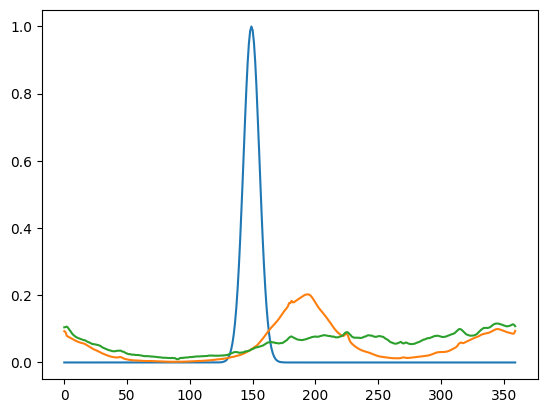

In [3]:
import matplotlib.pyplot as plt
# -----------------------
# 4) 取一个 sample，跑一次 forward
# -----------------------
# for SAMPLE_INDEX in range(100,200):
SAMPLE_INDEX = 7616
(inputs_list, gt) = dataset[SAMPLE_INDEX]      # inputs_list = [spectrogram], gt shape (3,)
spectrogram = inputs_list[0]                  # torch tensor, shape (2, 65, 26)
depth       = inputs_list[1]                  # torch tensor, shape (1, 128, 128)
gt_doa, gt_dis = gt
# 加 batch 维度 -> (1, 2, 65, 26)
spec = spectrogram.unsqueeze(0).to(DEVICE, dtype=torch.float32)
depth = depth.unsqueeze(0).to(DEVICE, dtype=torch.float32)

with torch.no_grad():
    pred_doa,pred_dis = model({"spectrogram": spec, "depth":depth})          # shape: (1, C) or (1, C+2) or (1,2)
    pred_doa = pred_doa.squeeze(0).cpu()
    pred_dis = pred_dis.squeeze(0).cpu()

    pred_doa_audio,pred_dis_audio = model_audio({"spectrogram": spec, "depth":depth})          # shape: (1, C) or (1, C+2) or (1,2)
    pred_doa_audio = pred_doa_audio.squeeze(0).cpu()
    pred_dis_audio = pred_dis_audio.squeeze(0).cpu()
    
gt_doa_np = gt_doa.cpu().numpy() if torch.is_tensor(gt_doa) else np.array(gt_doa)
gt_dis_np = gt_dis.cpu().numpy() if torch.is_tensor(gt_dis) else np.array(gt_dis)    
print("========== SAMPLE ==========")
print("Index:", SAMPLE_INDEX)
print("\n========== GT ==========")
# gt[0] 是 label index；gt[1:] 是 (x,y)
print("GT doa label:", int(np.argmax(gt_doa_np)))
print("pred doa   :", np.argmax(pred_doa))
print("GT dis label:", int(np.argmax(gt_dis)))
print("pred dis   :", np.argmax(pred_dis))
plt.plot(gt_doa_np)
plt.plot(pred_doa)
plt.plot(pred_doa_audio)


In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# =========================
# 0) 配置
# =========================
SEED = 0
K_PER_TARGET = 80          # 每个目标角度抽多少个
EPS_DEG = 2                # ±2°
TARGET_DEGS = list(range(0, 360, 20))  # 0,20,...,340  -> 18类

MAX_PRED_ERR_DEG = 30      # 关键：剔除预测误差 > 20° 的样本（circular）

TSNE_PERPLEXITY = 25
TSNE_LR = 200
TSNE_ITERS = 1500

rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)

# =========================
# 1) GT -> deg
# =========================
def doa_deg_from_onehot(gt_doa):
    if torch.is_tensor(gt_doa):
        gt_doa = gt_doa.detach().cpu().numpy()
    return int(np.argmax(gt_doa))  # 0..359

def circ_diff_deg(a, b):
    d = abs(a - b) % 360
    return min(d, 360 - d)

def assign_target_class(deg, targets, eps=2):
    best_t = None
    best_d = 999
    for t in targets:
        d = circ_diff_deg(deg, t)
        if d < best_d:
            best_d = d
            best_t = t
    if best_d <= eps:
        return best_t
    return None

# =========================
# 2) 预测角度（用于过滤）
# =========================
@torch.no_grad()
def pred_doa_deg(model_pred, spec_t, depth_t):
    """
    返回模型预测的 doa 角度（0..359）
    这里假设 model_pred({"spectrogram":..., "depth":...}) -> (pred_doa, pred_dis)
    且 pred_doa shape (1, 360)
    """
    pred_doa, _ = model_pred({"spectrogram": spec_t, "depth": depth_t})
    pred_deg = int(torch.argmax(pred_doa, dim=1).item())
    return pred_deg

# =========================
# 3) 分层固定抽样 + 预测误差过滤
# =========================
def stratified_indices_by_targets_filtered(
    dataset,
    targets,
    k_per_target=50,
    eps=2,
    max_pred_err_deg=20,
    max_scan=None,
    seed=0,
    filter_model=None,      # 用哪个模型来做过滤（建议：fusion model）
    device=None
):
    assert filter_model is not None, "filter_model must be provided for prediction-error filtering."
    assert device is not None, "device must be provided."

    rng = np.random.default_rng(seed)
    counts = {t: 0 for t in targets}
    picks  = {t: [] for t in targets}
    kept_err = {t: [] for t in targets}  # debug: 记录误差

    N = len(dataset) if max_scan is None else min(len(dataset), max_scan)
    order = np.arange(N)
    rng.shuffle(order)

    for idx in order:
        (inputs_list, gt) = dataset[idx]
        spectrogram = inputs_list[0]
        depth       = inputs_list[1]
        gt_doa, _    = gt

        gt_deg = doa_deg_from_onehot(gt_doa)
        t = assign_target_class(gt_deg, targets, eps=eps)
        if t is None:
            continue
        if counts[t] >= k_per_target:
            continue

        # ---- 用模型预测过滤：误差>max_pred_err_deg 丢弃 ----
        spec_t  = spectrogram.unsqueeze(0).to(device, dtype=torch.float32)
        depth_t = depth.unsqueeze(0).to(device, dtype=torch.float32)
        pd = pred_doa_deg(filter_model, spec_t, depth_t)
        err = circ_diff_deg(pd, gt_deg)
        if err > max_pred_err_deg:
            continue

        picks[t].append(idx)
        counts[t] += 1
        kept_err[t].append(err)

        if all(counts[tt] >= k_per_target for tt in targets):
            break

    selected = []
    y = []  # class id 0..len(targets)-1
    target_to_id = {t:i for i,t in enumerate(targets)}

    for t in targets:
        selected.extend(picks[t])
        y.extend([target_to_id[t]] * len(picks[t]))

    selected = np.array(selected, dtype=int)
    y = np.array(y, dtype=int)

    print("Targets:", targets)
    print("Counts per target:", {t: len(picks[t]) for t in targets})
    missing = [t for t in targets if len(picks[t]) < k_per_target]
    if len(missing) > 0:
        print("[Warn] targets not enough samples after filtering:", missing)
        print("Try reduce K_PER_TARGET, increase max_scan, loosen EPS_DEG or MAX_PRED_ERR_DEG.")

    # 额外打印一下平均误差（可选）
    avg_err = {t: (float(np.mean(kept_err[t])) if len(kept_err[t]) > 0 else None) for t in targets}
    print("Avg kept pred error per target (deg):", avg_err)

    return selected, y, target_to_id

# =========================
# 4) hook 抓 feature（不用 logits）
# =========================
class FeatureHook:
    def __init__(self, module: torch.nn.Module):
        self.feat = None
        self.h = module.register_forward_hook(self._hook)

    def _hook(self, module, inp, out):
        if isinstance(out, torch.Tensor):
            self.feat = out
        else:
            self.feat = None

    def close(self):
        self.h.remove()

def find_feature_layer(m: torch.nn.Module):
    # 优先：doa_head[0] 的输出（一般 128维），稳定可用
    if hasattr(m, "doa_head") and isinstance(m.doa_head, torch.nn.Sequential) and len(m.doa_head) > 0:
        return m.doa_head[0]  # Linear
    if hasattr(m, "fusion_fc"):
        return m.fusion_fc
    if hasattr(m, "spec_encoder") and hasattr(m.spec_encoder, "fc"):
        return m.spec_encoder.fc
    raise ValueError("Cannot find feature layer automatically; please set layer manually.")

@torch.no_grad()
def extract_feature(model_feat, spec, depth, layer=None):
    model_feat.eval()
    if layer is None:
        layer = find_feature_layer(model_feat)
    hk = FeatureHook(layer)
    _ = model_feat({"spectrogram": spec, "depth": depth})
    feat = hk.feat
    hk.close()
    if feat is None:
        raise RuntimeError("No feature captured. Check the hooked layer.")
    feat = feat.detach().cpu()
    while feat.dim() > 2:
        feat = feat.mean(dim=-1)
    feat = feat.squeeze(0).numpy()
    return feat

# =========================
# 5) 抽样（带过滤） -> 提特征 -> tSNE -> 画图
# =========================
# 这里用 fusion model 做“误差过滤”，让样本更干净
FILTER_MODEL = model          # <- 你要的：用我们的融合方法预测误差来剔除
# FILTER_MODEL = model_audio  # <- 如果你想让 audio-only 也更“干净”，可以改成它
# 或者更公平：后面我也给你写“都满足”怎么做

sel_idx, y, target_to_id = stratified_indices_by_targets_filtered(
    dataset,
    targets=TARGET_DEGS,
    k_per_target=K_PER_TARGET,
    eps=EPS_DEG,
    max_pred_err_deg=MAX_PRED_ERR_DEG,
    max_scan=None,
    seed=SEED,
    filter_model=FILTER_MODEL,
    device=DEVICE
)

X_fusion, X_audio = [], []
for idx in sel_idx:
    (inputs_list, gt) = dataset[idx]
    spectrogram = inputs_list[0]
    depth       = inputs_list[1]

    spec_t  = spectrogram.unsqueeze(0).to(DEVICE, dtype=torch.float32)
    depth_t = depth.unsqueeze(0).to(DEVICE, dtype=torch.float32)

    X_fusion.append(extract_feature(model, spec_t, depth_t, layer=None))
    X_audio.append(extract_feature(model_audio, spec_t, depth_t, layer=None))

X_fusion = np.asarray(X_fusion, dtype=np.float32)
X_audio  = np.asarray(X_audio,  dtype=np.float32)

print("Feature shapes:", X_fusion.shape, X_audio.shape, "Labels:", y.shape)

def run_tsne(X, seed=0):
    tsne = TSNE(
        n_components=2,
        perplexity=TSNE_PERPLEXITY,
        learning_rate=TSNE_LR,
        n_iter=TSNE_ITERS,
        init="pca",
        random_state=seed,
        verbose=1,
    )
    return tsne.fit_transform(X)



Targets: [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340]
Counts per target: {0: 80, 20: 80, 40: 80, 60: 80, 80: 80, 100: 80, 120: 80, 140: 80, 160: 80, 180: 80, 200: 80, 220: 80, 240: 80, 260: 80, 280: 80, 300: 80, 320: 80, 340: 80}
Avg kept pred error per target (deg): {0: 0.7125, 20: 6.075, 40: 9.9375, 60: 9.7375, 80: 5.7125, 100: 7.0, 120: 9.875, 140: 8.475, 160: 3.6875, 180: 1.225, 200: 5.5375, 220: 9.95, 240: 6.775, 260: 5.6625, 280: 7.45, 300: 8.475, 320: 9.7875, 340: 4.9125}
Feature shapes: (1440, 128) (1440, 128) Labels: (1440,)


  warnings.warn(



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1440 samples in 0.000s...
[t-SNE] Computed neighbors for 1440 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1440
[t-SNE] Computed conditional probabilities for sample 1440 / 1440
[t-SNE] Mean sigma: 1.904072
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.855141


  warnings.warn(



[t-SNE] KL divergence after 1500 iterations: 0.563163
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1440 samples in 0.000s...
[t-SNE] Computed neighbors for 1440 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1440
[t-SNE] Computed conditional probabilities for sample 1440 / 1440
[t-SNE] Mean sigma: 3.904603
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.011345


  cmap = plt.cm.get_cmap("tab20", len(TARGET_DEGS))



[t-SNE] KL divergence after 1500 iterations: 0.650428


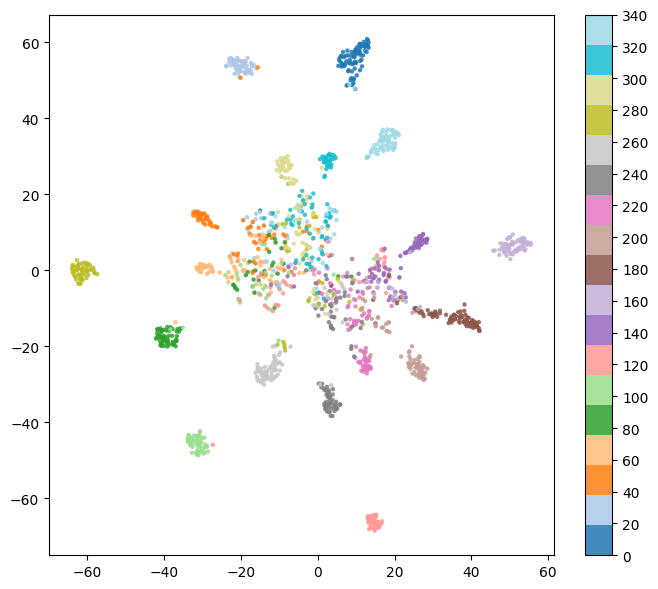

In [33]:
TSNE_PERPLEXITY = 30
TSNE_LR = 200
TSNE_ITERS = 1500
Z_fusion = run_tsne(X_fusion, seed=SEED)
Z_audio  = run_tsne(X_audio,  seed=SEED)

id_to_target = {v:k for k,v in target_to_id.items()}

def plot_tsne(Z, y, title):
    plt.figure(figsize=(7, 6))
    cmap = plt.cm.get_cmap("tab20", len(TARGET_DEGS))
    sc = plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap=cmap, s=10, alpha=0.85, linewidths=0)
    # plt.title(title)
    # plt.axis("off")

    ticks = np.arange(len(TARGET_DEGS))
    cbar = plt.colorbar(sc, ticks=ticks)
    cbar.ax.set_yticklabels([str(id_to_target[i]) for i in ticks])
    # cbar.set_label(f"Target DOA (deg), bin=±{EPS_DEG}°, filtered by pred_err≤{MAX_PRED_ERR_DEG}°")
    plt.tight_layout()
    plt.savefig(
    "vis/tsne_ours",
    dpi=600,
    transparent=True,  
    bbox_inches="tight",
    pad_inches=0.02
    )
    plt.show()

plot_tsne(Z_fusion, y, "t-SNE (Fusion features) — target angles 0,20,...,340 (±2°) + pred_err filter")
# plot_tsne(Z_audio,  y, "t-SNE (Audio-only features) — SAME selected samples for fair comparison")


In [23]:
SAVE_PATH = "vis/tsne_selected_indices.npz"
np.savez(
    SAVE_PATH,
    sel_idx=sel_idx.astype(np.int32),
    y=y.astype(np.int32),
    targets=np.array(TARGET_DEGS, dtype=np.int32),
    eps_deg=np.int32(EPS_DEG),
    max_pred_err_deg=np.int32(MAX_PRED_ERR_DEG),
    k_per_target=np.int32(K_PER_TARGET),
    seed=np.int32(SEED),
)
print("Saved selection to:", os.path.abspath(SAVE_PATH))

Saved selection to: /home/Disk/yyz/sound-spaces/vis/tsne_selected_indices.npz


Pred DOA cls: 291 Pred DIS cls: 75 gt_doa 109


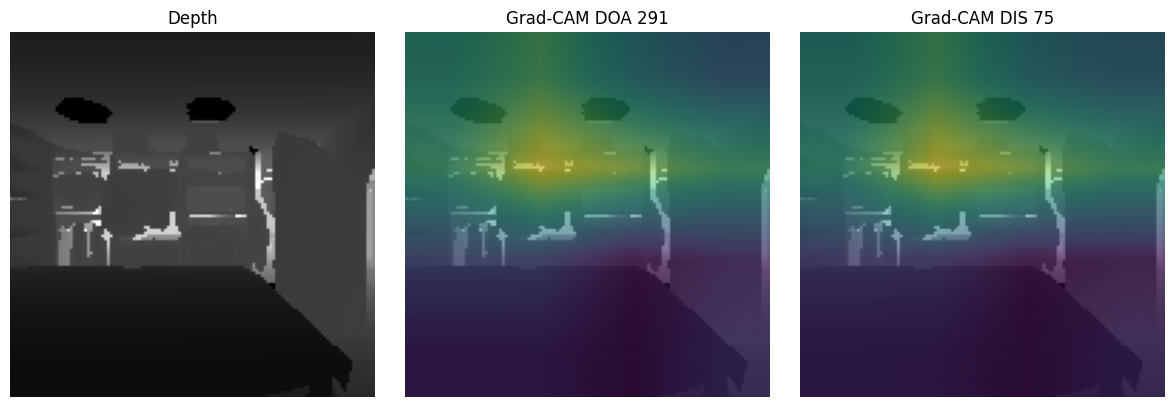

In [24]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model: torch.nn.Module, target_layer: torch.nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        def fwd_hook(module, inp, out):
            self.activations = out
            # 关键：让 activation 保留梯度（即使不是 leaf）
            if isinstance(out, torch.Tensor):
                out.retain_grad()

        def bwd_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.h1 = self.target_layer.register_forward_hook(fwd_hook)
        self.h2 = self.target_layer.register_full_backward_hook(bwd_hook)

    def remove(self):
        self.h1.remove()
        self.h2.remove()

    @staticmethod
    def normalize(cam: torch.Tensor) -> torch.Tensor:
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam

    def cam(self, inputs: dict, branch="doa", class_idx=None, upsample_size=(128,128)):
        self.model.eval()
        self.model.zero_grad(set_to_none=True)

        pred_doa, pred_dis = self.model(inputs)
        logits = pred_doa if branch == "doa" else pred_dis

        if class_idx is None:
            class_idx = int(torch.argmax(logits, dim=1).item())

        score = logits[:, class_idx].sum()

        self.model.zero_grad(set_to_none=True)
        score.backward(retain_graph=True)

        A = self.activations
        dA = self.gradients

        # 关键诊断：把缺哪一步打印出来
        if A is None:
            raise RuntimeError("No activations captured. target_layer 没有走到（可能选错层）")
        if dA is None:
            raise RuntimeError("No gradients captured. depth 分支可能没建计算图（看下面的 depth.requires_grad 处理）")

        w = dA.mean(dim=(2,3), keepdim=True)
        cam = F.relu((w * A).sum(dim=1, keepdim=True))
        cam = F.interpolate(cam, size=upsample_size, mode="bilinear", align_corners=False)
        cam = self.normalize(cam)[0,0].detach().cpu().numpy()
        return cam, pred_doa.detach(), pred_dis.detach(), class_idx


SAMPLE_INDEX = 766
(inputs_list, gt) = dataset[SAMPLE_INDEX]      # inputs_list = [spectrogram], gt shape (3,)
spectrogram = inputs_list[0]                  # torch tensor, shape (2, 65, 26)
depth       = inputs_list[1]                  # torch tensor, shape (1, 128, 128)
gt_doa, gt_dis = gt
# 加 batch 维度 -> (1, 2, 65, 26)
spec = spectrogram.unsqueeze(0).to(DEVICE, dtype=torch.float32)
depth = depth.unsqueeze(0).to(DEVICE, dtype=torch.float32)


# ----------------------------
# 1) 选 depth_encoder 的 target layer（你这个结构最推荐这层）
# ----------------------------
target_layer = model.depth_encoder.features[7][1].conv2  

cam_extractor = GradCAM(model, target_layer)

# ----------------------------
# 2) 关键：不要用 torch.no_grad()
#    关键：让 depth 输入 requires_grad=True，确保 depth 分支建图
# ----------------------------
spec_cam  = spec  # spec 已经在 DEVICE 上
depth_cam = depth.clone().detach().requires_grad_(True)  # <= 关键

inputs = {"spectrogram": spec_cam, "depth": depth_cam}

cam_doa, pred_doa_t, pred_dis_t, doa_cls = cam_extractor.cam(
    inputs, branch="doa", class_idx=None, upsample_size=(depth.shape[-2], depth.shape[-1])
)

cam_dis, _, _, dis_cls = cam_extractor.cam(
    inputs, branch="dis", class_idx=None, upsample_size=(depth.shape[-2], depth.shape[-1])
)

print("Pred DOA cls:", doa_cls, "Pred DIS cls:", dis_cls,"gt_doa",int(np.argmax(gt_doa)))

# ----------------------------
# 3) 可视化
# ----------------------------
depth_np = depth_cam[0,0].detach().cpu().numpy()
depth_vis = (depth_np - depth_np.min()) / (depth_np.max() - depth_np.min() + 1e-8)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Depth"); plt.imshow(depth_vis, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"Grad-CAM DOA {doa_cls}"); plt.imshow(depth_vis, cmap="gray"); plt.imshow(cam_doa, alpha=0.5); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Grad-CAM DIS {dis_cls}"); plt.imshow(depth_vis, cmap="gray"); plt.imshow(cam_dis, alpha=0.5); plt.axis("off")
plt.tight_layout(); plt.show()

cam_extractor.remove()
